In [1]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
pd.set_option('display.max_columns', None)

# Load a sort of library file with csv column names, shared with script that preps csv files for import
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

import prepcsv.lib.prepcsv as prepcsv
csv_columns = prepcsv.file_columns
print(csv_columns.keys())

df = {}
for filename, column_names in csv_columns.items():
    cols = [c for c in csv_columns[filename] if c != 'url']
    df[filename] = pd.read_csv(f'./f1db_csv/{filename}.csv', usecols=cols)

dict_keys(['constructors', 'races', 'circuits', 'results', 'driver', 'driver_standings', 'qualifying', 'status'])


In [2]:
# Merge dataset to get all the data in a couple of usefull (but big) dataframes

def join_datasets(left, right, on):
    return df[left].join(df[right].set_index(on), on=on, rsuffix=f'_{right}')
df['RaCi']         = join_datasets('races', 'circuits', 'circuitId')
df['ReDr']         = join_datasets('results', 'driver', 'driverId') 
df['ReDrCo']       = join_datasets('ReDr', 'constructors', 'constructorId')
df['ReDrCoRaCi']   = join_datasets('ReDrCo', 'RaCi', 'raceId')
df['ReDrCoRaCiSt'] = join_datasets('ReDrCoRaCi', 'status', 'statusId')
df['StDr']         = join_datasets('driver_standings', 'driver', 'driverId')
df['StDrRa']       = join_datasets('StDr', 'races', 'raceId')
big_results = df['ReDrCoRaCiSt']
big_results

,resultId,raceId,driverId,constructorId,number,grid,position,postionText,positionOrder,points,laps,time,milliseconds,fastestLap,rank,fastestLapTime,fastestLapSpeed,statusId,driverRef,number_driver,code,forename,surname,dob,nationality,constructorRef,teamName,nationality_constructors,year,round,circuitId,circuitName,date,time_RaCi,circuitRef,circuitName_circuits,location,country,lat,lng,alt,status
0,1,18,1,1,22,1,1,1,1,10.0,58,1:34:50.616,5690616,39,2,1:27.452,218.300,1,hamilton,44,HAM,Lewis,Hamilton,1985-01-07,British,mclaren,McLaren,British,2008,1,1,Australian Grand Prix,2008-03-16,04:30:00,albert_park,Albert Park Grand Prix Circuit,Melbourne,Australia,-37.8497,144.968,10,Finished
1,2,18,2,2,3,5,2,2,2,8.0,58,+5.478,5696094,41,3,1:27.739,217.586,1,heidfeld,\N,HEI,Nick,Heidfeld,1977-05-10,German,bmw_sauber,BMW Sauber,German,2008,1,1,Australian Grand Prix,2008-03-16,04:30:00,albert_park,Albert Park Grand Prix Circuit,Melbourne,Australia,-37.8497,144.968,10,Finished
2,3,18,3,3,7,7,3,3,3,6.0,58,+8.163,5698779,41,5,1:28.090,216.719,1,rosberg,6,ROS,Nico,Rosberg,1985-06-27,German,williams,Williams,British,2008,1,1,Australian Grand Prix,2008-03-16,04:30:00,albert_park,Albert Park Grand Prix Circuit,Melbourne,Australia,-37.8497,144.968,10,Finished
3,4,18,4,4,5,11,4,4,4,5.0,58,+17.181,5707797,58,7,1:28.603,215.464,1,alonso,14,ALO,Fernando,Alonso,1981-07-29,Spanish,renault,Renault,French,2008,1,1,Australian Grand Prix,2008-03-16,04:30:00,albert_park,Albert Park Grand Prix Circuit,Melbourne,Australia,-37.8497,144.968,10,Finished
4,5,18,5,1,23,3,5,5,5,4.0,58,+18.014,5708630,43,1,1:27.418,218.385,1,kovalainen,\N,KOV,Heikki,Kovalainen,1981-10-19,Finnish,mclaren,McLaren,British,2008,1,1,Australian Grand Prix,2008-03-16,04:30:00,albert_park,Albert Park Grand Prix Circuit,Melbourne,Australia,-37.8497,144.968,10,Finished
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24535,24541,1026,841,51,99,11,16,16,16,0.0,51,\N,\N,51,6,1:32.369,226.322,11,giovinazzi,99,GIO,Antonio,Giovinazzi,1993-12-14,Italian,alfa,Alfa Romeo,Italian,2019,17,22,Japanese Grand Prix,2019-10-13,05:10:00,suzuka,Suzuka Circuit,Suzuka,Japan,34.8431,136.541,\N,+1 Lap
24536,24542,1026,825,210,20,19,17,17,17,0.0,51,\N,\N,49,3,1:31.732,227.894,11,kevin_magnussen,20,MAG,Kevin,Magnussen,1992-10-05,Danish,haas,Haas F1 Team,American,2019,17,22,Japanese Grand Prix,2019-10-13,05:10:00,suzuka,Suzuka Circuit,Suzuka,Japan,34.8431,136.541,\N,+1 Lap
24537,24543,1026,847,3,63,18,18,18,18,0.0,50,\N,\N,27,18,1:35.458,218.998,12,russell,63,RUS,George,Russell,1998-02-15,British,williams,Williams,British,2019,17,22,Japanese Grand Prix,2019-10-13,05:10:00,suzuka,Suzuka Circuit,Suzuka,Japan,34.8431,136.541,\N,+2 Laps
24538,24544,1026,9,3,88,0,19,19,19,0.0,50,\N,\N,44,19,1:36.332,217.012,12,kubica,88,KUB,Robert,Kubica,1984-12-07,Polish,williams,Williams,British,2019,17,22,Japanese Grand Prix,2019-10-13,05:10:00,suzuka,Suzuka Circuit,Suzuka,Japan,34.8431,136.541,\N,+2 Laps


## Print how many victorys, and the list of victories

In [6]:
def wins_of_driver(driver):
    res = big_results[(big_results['driverRef'] == driver) & (big_results['position'] == '1')]
    print(len(res))
    print(res[['year','circuitName']])
wins_of_driver('max_verstappen')

7
       year           circuitName
23000  2016    Spanish Grand Prix
23657  2017  Malaysian Grand Prix
23717  2017    Mexican Grand Prix
23937  2018   Austrian Grand Prix
24137  2018    Mexican Grand Prix
24360  2019   Austrian Grand Prix
24400  2019     German Grand Prix


## Plot the number of races per season

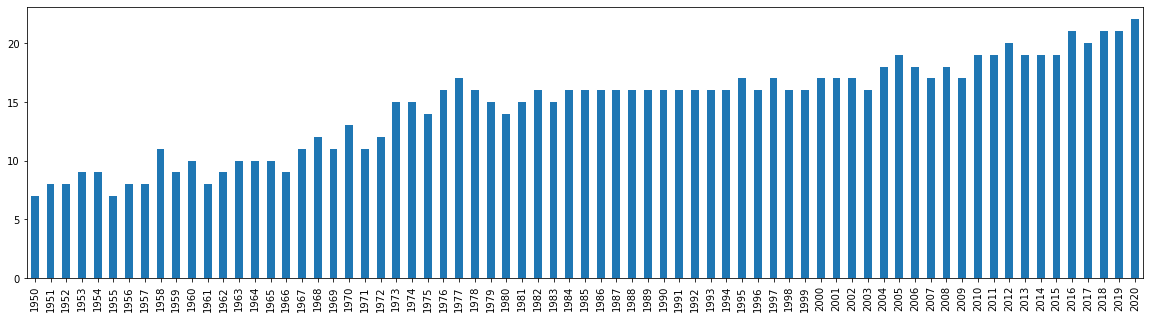

In [4]:
season_lengths = { year : len(df['races'][df['races']['year'] == year]) for year in range(1950, 2021)}
ts = pd.Series(season_lengths)
p = ts.plot(kind='bar', figsize=(20,5))
plt.show()

## Number of race wins per driver

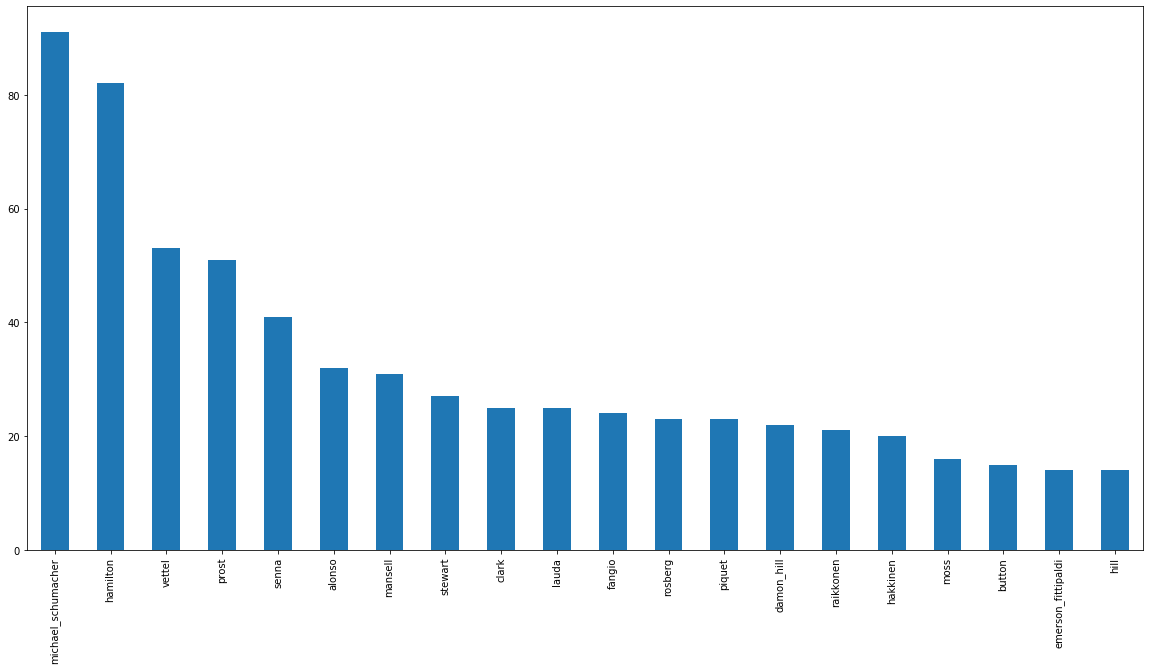

michael_schumacher    91
hamilton              82
vettel                53
prost                 51
senna                 41
alonso                32
mansell               31
stewart               27
clark                 25
lauda                 25
fangio                24
rosberg               23
piquet                23
damon_hill            22
raikkonen             21
hakkinen              20
moss                  16
button                15
emerson_fittipaldi    14
hill                  14
Name: driverRef, dtype: int64

In [7]:
# winning_drivers = df_results_drivers_races_constructors[df_results_drivers['position'] == '1']
winning_drivers = big_results[big_results['position'] == '1']
win_counts = winning_drivers['driverRef'].value_counts()
win_counts[:20].plot(kind="bar", figsize=(20,10))
plt.show()
win_counts[:20]

In [66]:
def when_champion(year):
    season_lengths = { year : len(df['races'][df['races']['year'] == year]) for year in range(1950, 2021)}
    standings = df['StDrRa']
    season_races = pd.Series(df['ReDrCoRaCi'][df['ReDrCoRaCi']['year'] == year]['raceId'])
    season_standings = standings[standings['raceId'].isin(season_races)]
    points_for_winning = df['ReDrCoRaCi'][df['ReDrCoRaCi']['raceId'].isin(season_races)]['points'].max()
    for roundNumber in range(1,season_lengths[year]+1):
        r = season_standings[season_standings['round'] == roundNumber]
        leader = r[r['position'] == 1]
        runnerup = r[r['position'] == 2]
        rounds_left = season_lengths[year] - roundNumber
        if (rounds_left * points_for_winning) < leader.iloc[0]['points'] - runnerup.iloc[0]['points']:
            return (roundNumber, season_lengths[year])
when_champion(2016)

(21, 21)

## List every seasons champion

In [74]:
season_lengths = { year : len(df['races'][df['races']['year'] == year]) for year in range(1950, 2021)}
standings = df['StDrRa']
for year in range(1950, 2019):
    season_races = pd.Series(df['races'][df['races']['year'] == year]['raceId'])
    season_standings = standings[standings['raceId'].isin(season_races)]
    last_round = season_standings[season_standings['round'] == season_lengths[year]]
    champion = last_round[last_round['position'] == 1]
    when = when_champion(year)
    percentage = when[0]/(when[1]/100)
    print('{}: {} {} {} {:.1f}'.format(champion.iloc[0]['year'], 
                                champion.iloc[0]['forename'], 
                                champion.iloc[0]['surname'],
                                when,
                                percentage))

1950: Nino Farina (7, 7) 100.0
1951: Juan Fangio (8, 8) 100.0
1952: Alberto Ascari (7, 8) 87.5
1953: Alberto Ascari (8, 9) 88.9
1954: Juan Fangio (7, 9) 77.8
1955: Juan Fangio (6, 7) 85.7
1956: Juan Fangio (8, 8) 100.0
1957: Juan Fangio (7, 8) 87.5
1958: Mike Hawthorn (11, 11) 100.0
1959: Jack Brabham (9, 9) 100.0
1960: Jack Brabham (10, 10) 100.0
1961: Phil Hill (8, 8) 100.0
1962: Graham Hill (9, 9) 100.0
1963: Jim Clark (8, 10) 80.0
1964: John Surtees (10, 10) 100.0
1965: Jim Clark (8, 10) 80.0
1966: Jack Brabham (7, 9) 77.8
1967: Denny Hulme (11, 11) 100.0
1968: Graham Hill (12, 12) 100.0
1969: Jackie Stewart (8, 11) 72.7
1970: Jochen Rindt (12, 13) 92.3
1971: Jackie Stewart (8, 11) 72.7
1972: Emerson Fittipaldi (10, 12) 83.3
1973: Jackie Stewart (13, 15) 86.7
1974: Emerson Fittipaldi (15, 15) 100.0
1975: Niki Lauda (13, 14) 92.9
1976: James Hunt (16, 16) 100.0
1977: Niki Lauda (15, 17) 88.2
1978: Mario Andretti (15, 16) 93.8
1979: Jody Scheckter (15, 15) 100.0
1980: Alan Jones (14,

- dnf percentage per driver
- plot of qualifing laptimes per cicuit through the years, anotaded with rule changes
  (v12, v8, v6, drs, kers, double diffuser introduction/banning)
- rank drivers on dominance, measuring outqualifing team mate, positons gained in race, if won by how much time, point scoring streaks, lap records, 
